# Assignment 2 EEG Data Analysis

*This assignment is an exploration into a dataset of EEG data on patients. The data contains EEG measurements for people who were first asked to keep their eyes open (oa) and then closed (oc) for around 4-5 minutes.*

*The main aim is to give you an application of the Discrete Fourier Transform on real world data. As this step can be done in a single function a lot of the time spent on this exercise will be on visually inspecting the data and trying different classifiers on the data you have produced.*

Apart from the usual libraries you have been using in this course, you will have to install mne via pip or conda.

In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.signal as signal

from os.path import join

import pandas as pd
from tqdm.notebook import tqdm

In [2]:
path_data = "egg_data_assignment_2"
data_oa = []
data_oc = []
sample_rate = 250   # DO NOT CHANGE THIS

for folder in tqdm(os.listdir(path_data), desc="Loading data"):
    for filename in os.listdir(join(path_data, folder)):
        df = pd.read_csv(join(path_data, folder, filename), sep=",", index_col=0)
        if "oa" in filename:
            data_oa.append(df.values)
        else:
            data_oc.append(df.values)

Loading data:   0%|          | 0/8 [00:00<?, ?it/s]

In [4]:
print(F"Loaded data from {len(data_oa)} patients")

Loaded data from 8 patients


### Exercise 1
**1. Let's take a look at the data by investigating the shape of it. What is the maximum frequency we can represent given the length?**

*Hint: Remember to factor in the sample rate*

In [5]:
for d_oc, d_oa in zip(data_oc, data_oa):
    print(f"Shape of OC: {d_oc.shape}, Shape of OA: {d_oa.shape}")

Shape of OC: (20, 50000), Shape of OA: (20, 50000)
Shape of OC: (20, 50000), Shape of OA: (20, 50000)
Shape of OC: (20, 50000), Shape of OA: (20, 50000)
Shape of OC: (20, 50000), Shape of OA: (20, 50000)
Shape of OC: (20, 50000), Shape of OA: (20, 50000)
Shape of OC: (20, 50000), Shape of OA: (20, 50000)
Shape of OC: (20, 50000), Shape of OA: (20, 50000)
Shape of OC: (20, 50000), Shape of OA: (20, 50000)


*Now we want to center all the data around the same value (0), in eeg data analysis terms this is called referencing. Here we will apply a simple average referencing*

### Exercise 1

**1. Implement the following function:**


In [6]:
def set_reference(eeg_data, ref_channels):
    """Take the mean of the reference channels and subtract that from the data"""
    eeg_masked = eeg_data[ref_channels]
    ref_signal = np.mean(eeg_masked, axis=0)
    re_referenced_data = eeg_data - ref_signal
    return re_referenced_data

*We will reference each patient's data individually:*

In [7]:
for i in range(len(data_oa)):
    data_oc[i] = set_reference(data_oc[i], np.arange(20))
    data_oa[i] = set_reference(data_oa[i], np.arange(20))

### Exercise 1

**2. Using the following plotting function, have a look at the data and comment on the quality of it:**


In [8]:
def plot_eeg_mne_style(eeg_data, ch_names, sampling_rate):
    """
    Plot EEG data in an MNE-style plot for each channel.

    Parameters:
    eeg_data : np.ndarray
        The EEG data with shape (n_channels, n_points).
    ch_names : list of str
        List of channel names (must be of length n_channels).
    sampling_rate : float
        The sampling rate of the EEG data (in Hz).
    """    
    # Create MNE info structure with channel names and sampling rate
    info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types='eeg')
    
    # Create MNE RawArray object with the data
    raw = mne.io.RawArray(eeg_data, info)
    
    # Plot the EEG data with MNE's built-in plot function
    raw.plot(scalings='auto', show=True, block=True)
    plt.show()

Creating RawArray with float64 data, n_channels=20, n_times=50000
    Range : 0 ... 49999 =      0.000 ...   199.996 secs
Ready.
Using matplotlib as 2D backend.


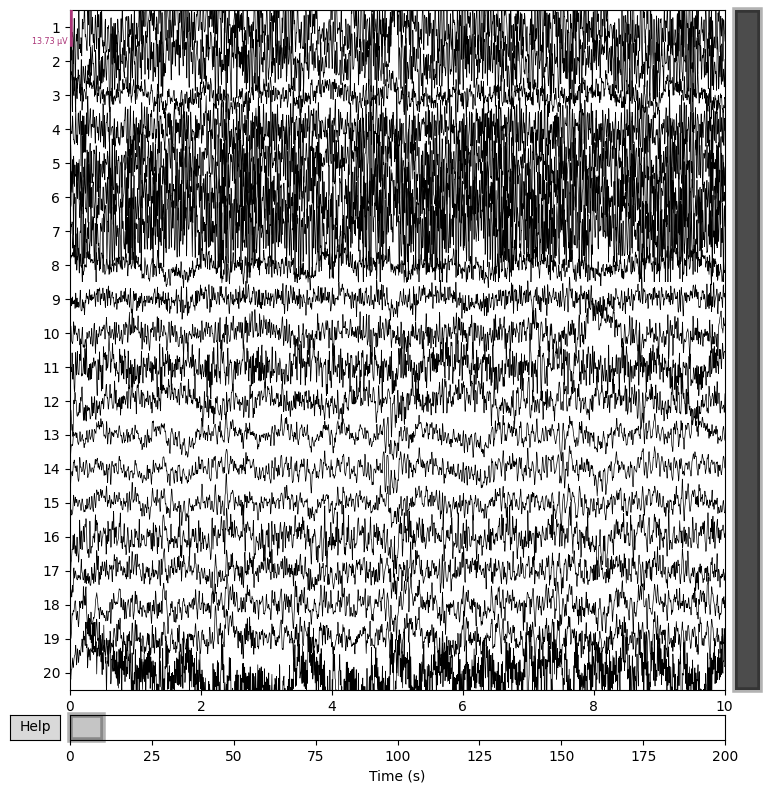

In [9]:
channel_names = np.arange(1,21,1).astype(str).tolist()
plot_eeg_mne_style(data_oa[4], ch_names=channel_names, sampling_rate=sample_rate)

### Exercise 2 Discrete Fourier Transform
*This exercise should seem very familiar by now and is included here as this will be the main focus if you draw this assignment at the exam*


*You are given the following information about a sampled signal:

- Sampling rate: $f_s = 4$
- Duration: $1s$
- Signal values $x(n) = [ 0,  1,  0, -1]$

**1. Using the formula for fourier coefficients: $c_k = \sum_{n = 0}^{N-1} x(n) e^{-i 2\pi \frac{kn}{N}}$, calculate the fourier coefficient for the signal $x(n)$ corresponding to $k = 1$**

$\dots$

**2. Calculate the frequency that the fourier coefficient for $k = 1$ corresponds to**

$\dots$

**3. Calculate the amplitude of the frequency that corresponds to the fourier coefficient for $k = 1$**

$\dots$

**4. Given the signal values for the above signal, what is the original analog signal?**

$\dots$

**$\star$ 5 Perform the same 4 exercises above but for $k = 3$ and for following values:**

- Sampling rate: $f_s = 4$
- Duration: $2s$
- Signal values $x(n) = [ 0,     2.828, -4,     2.828,  0,    -2.828,  4,    -2.828]$


$\dots$


### Exercise 3 Frequency Domain and Filtering

**1. Create a function that takes a signal and applies a bandpass filter in the time domain:**

In [36]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data


**2. Complete the following function which takes a signal and computes its power spectrum and removes frequencies outside the min and max in order to remove redundant information after filtering**

In [37]:
def compute_power_spectrum(signal, sampling_rate, min_freq=None, max_freq=None):
    """
    Computes the power spectrum for each channel in the signal.

    Parameters:
    signal : np.ndarray
        Input signal with shape (n_channels, n_points)
    sampling_rate : float
        The sampling rate of the signal (in Hz).

    Returns:
    freqs : np.ndarray
        The frequencies corresponding to the power spectrum.
    power_spectrum : np.ndarray
        Power spectrum of each channel with shape (n_channels, n_points//2).
    """
    n_channels, n_points = signal.shape
    
    # Perform the FFT for each channel
    fft_vals = np.fft.rfft(signal, axis=1)
    
    # Compute the power spectrum (squared magnitude of the FFT)
    power_spectrum = np.abs(fft_vals) ** 2
    
    # Compute the corresponding frequencies
    freqs = np.fft.rfftfreq(n_points, 1 / sampling_rate)
    
    if min_freq is not None:
        power_spectrum = power_spectrum[:, min_freq <= freqs]
        freqs = freqs[min_freq <= freqs]

    if max_freq is not None:
        power_spectrum = power_spectrum[:, freqs <= max_freq]
        freqs = freqs[freqs <= max_freq]
        
    return freqs, power_spectrum

In [38]:
def plot_power_spectrum_overlay(freqs, power_spectrum, ch_names, show=False, title=""):
    """
    Plot the power spectrum for all channels on the same plot.

    Parameters:
    eeg_data : np.ndarray
        The EEG data with shape (n_channels, n_points).
    sampling_rate : float
        The sampling rate of the EEG data (in Hz).
    ch_names : list of str
        List of channel names.
    """
    colors = cm.viridis(np.linspace(0, 1, len(ch_names)))

    for i, ch_name in enumerate(ch_names):
        plt.plot(freqs, power_spectrum[i], color=colors[i], label=ch_name)

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.title('Power Spectrum for EEG Channels' if not title else title)
    plt.tight_layout()
    if show:
        plt.show()

*We have been advised by Ivana (Human Cognition lecturer and EEG researcher), that we should take a look at the frequencies between 5 and 20 Hz in order to get a distinction between OC and OA. Here we plot all the power spectra from each channel on top of one another*

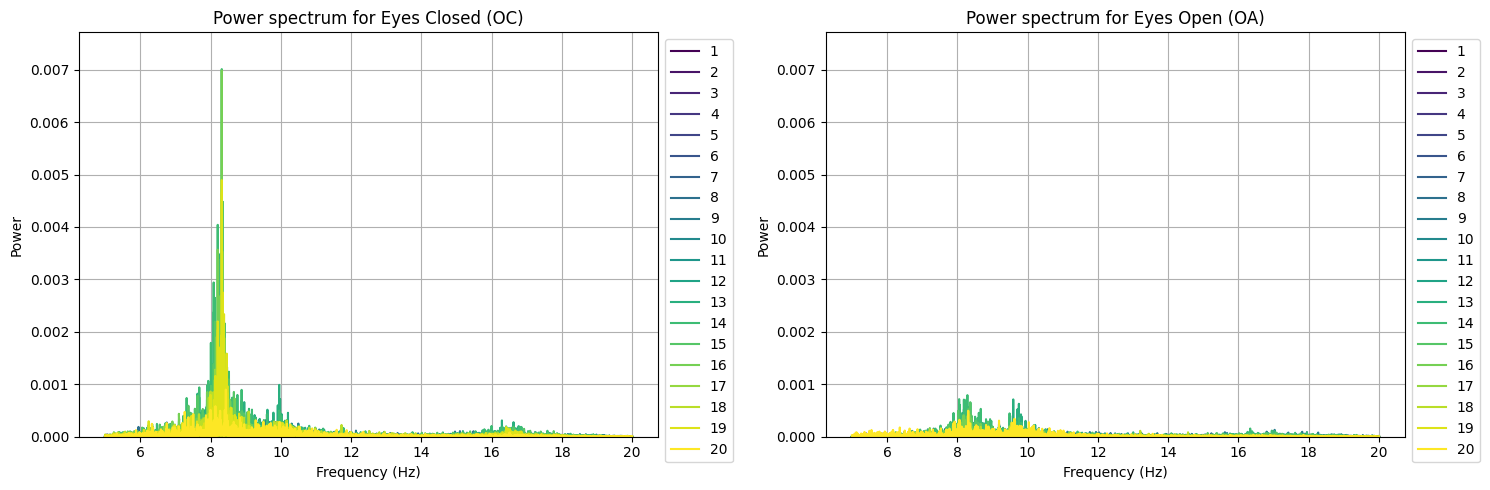

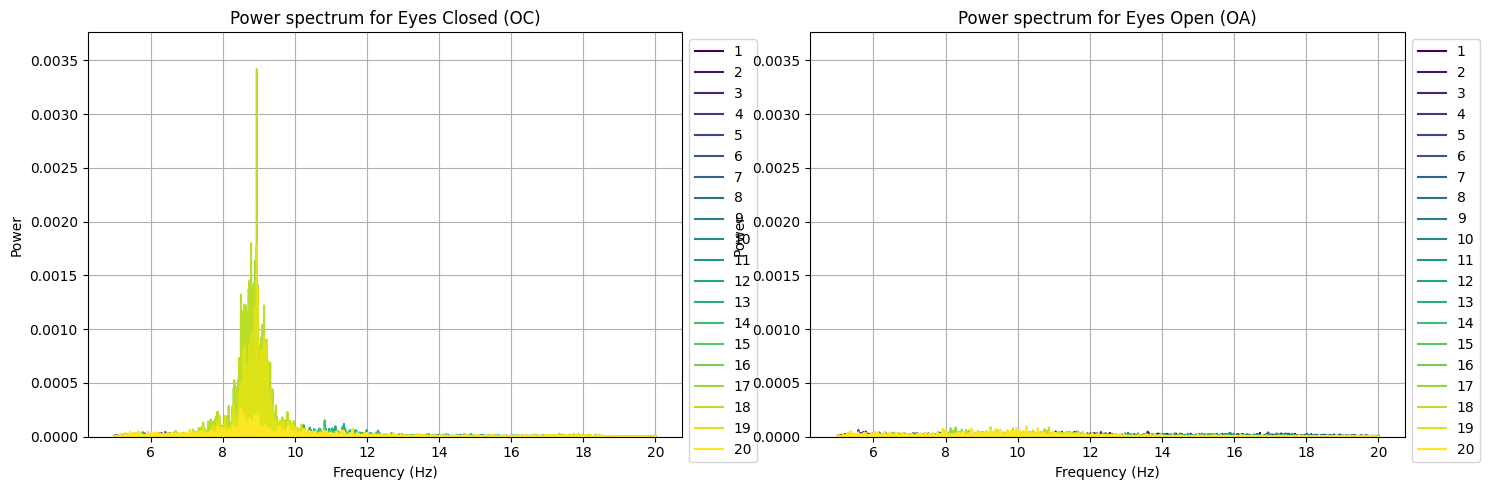

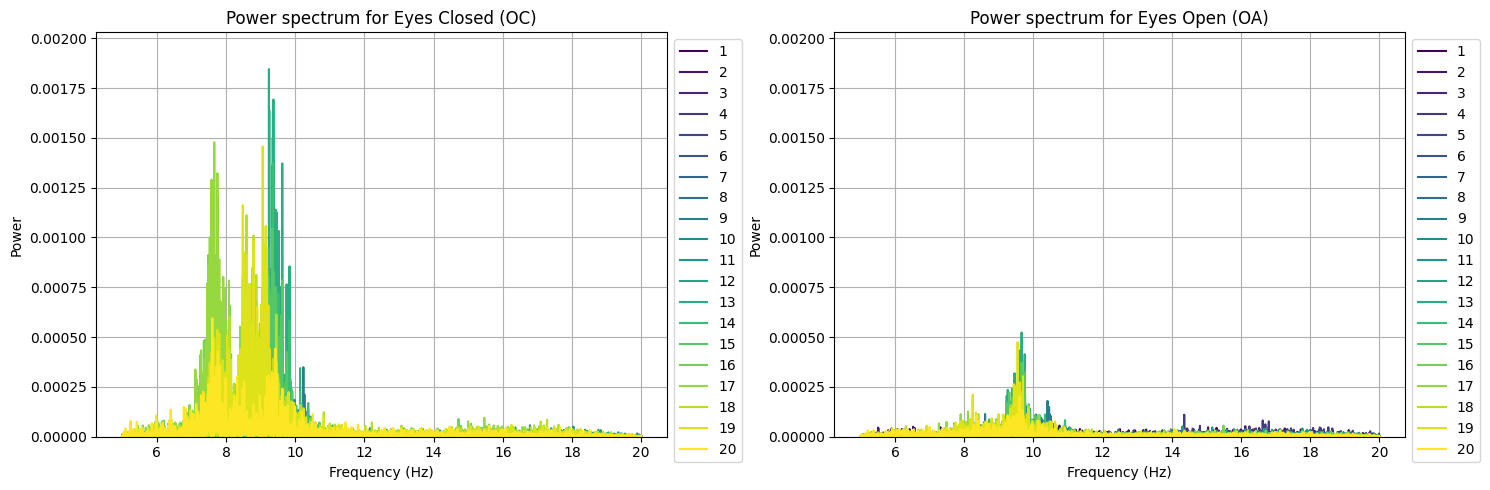

In [39]:
segments_to_plot = [0, 3, 5]
min_freq=5
max_freq=20
for segment in segments_to_plot:
    plt.subplots(1, 2, figsize=(15, 5))
    
    data_oc_time_filtered = bandpass_filter(data_oc[segment], min_freq, max_freq, sample_rate)
    data_oa_time_filtered = bandpass_filter(data_oa[segment], min_freq, max_freq, sample_rate)
    # Compute power spectra for both conditions
    freqs_oc, power_spectrum_oc = compute_power_spectrum(data_oc_time_filtered, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq)
    freqs_oa, power_spectrum_oa = compute_power_spectrum(data_oa_time_filtered, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq)
    
    # Determine the y-limit based on the maximum value of both power spectra
    y_max = max(power_spectrum_oc.max(), power_spectrum_oa.max())
    
    plt.subplot(1, 2, 1)
    plot_power_spectrum_overlay(freqs_oc, power_spectrum_oc, channel_names, title=f"Power spectrum for Eyes Closed (OC)")
    plt.ylim([0, y_max + y_max / 10])
    plt.subplot(1, 2, 2)
    plot_power_spectrum_overlay(freqs_oa, power_spectrum_oa, channel_names, title=f"Power spectrum for Eyes Open (OA)")
    plt.ylim([0, y_max + y_max / 10])
    plt.show()

**2. Using the loop above take a look at the spectrograms for eyes open and eyes closed.** 
- Is there a noticeable difference between the two? How could we use this difference for classification?
- Discuss whether the conditions of our fft are sufficient to avoid spectral leakage
 
 

**3. The channels at index 17 and 18 are known to be correlated to have open vs closed eyes, plot these:**

In [14]:
optical_channel_slice = slice(17, 19)
data_oc_optical_channels = [arr[optical_channel_slice] for arr in data_oc]
data_oa_optical_channels = [arr[optical_channel_slice] for arr in data_oa]

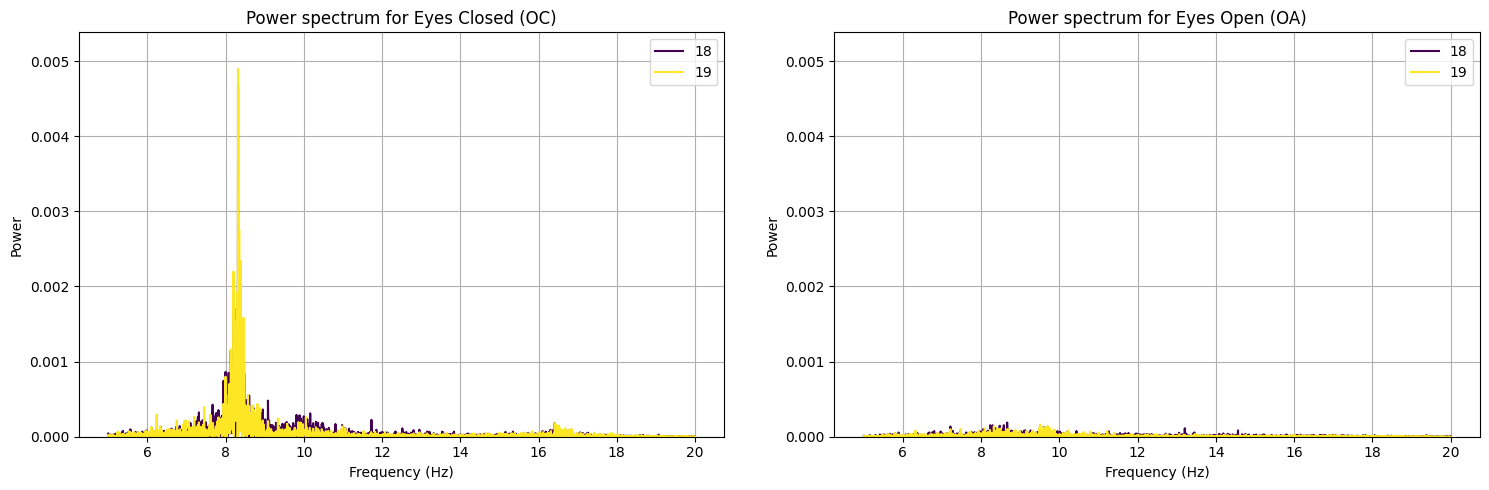

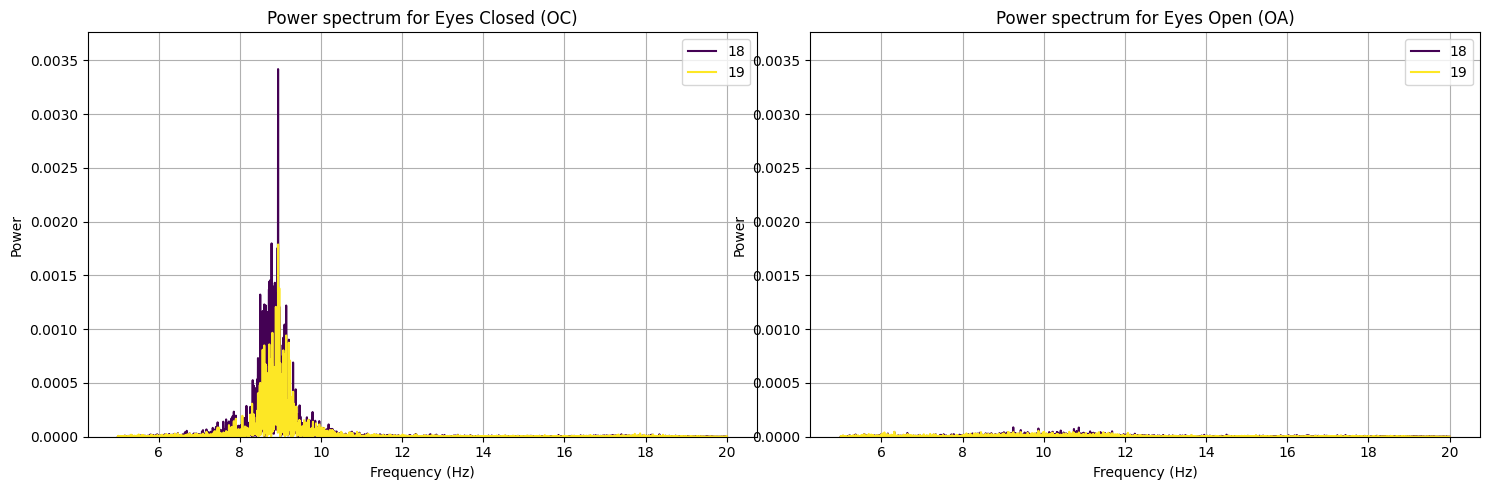

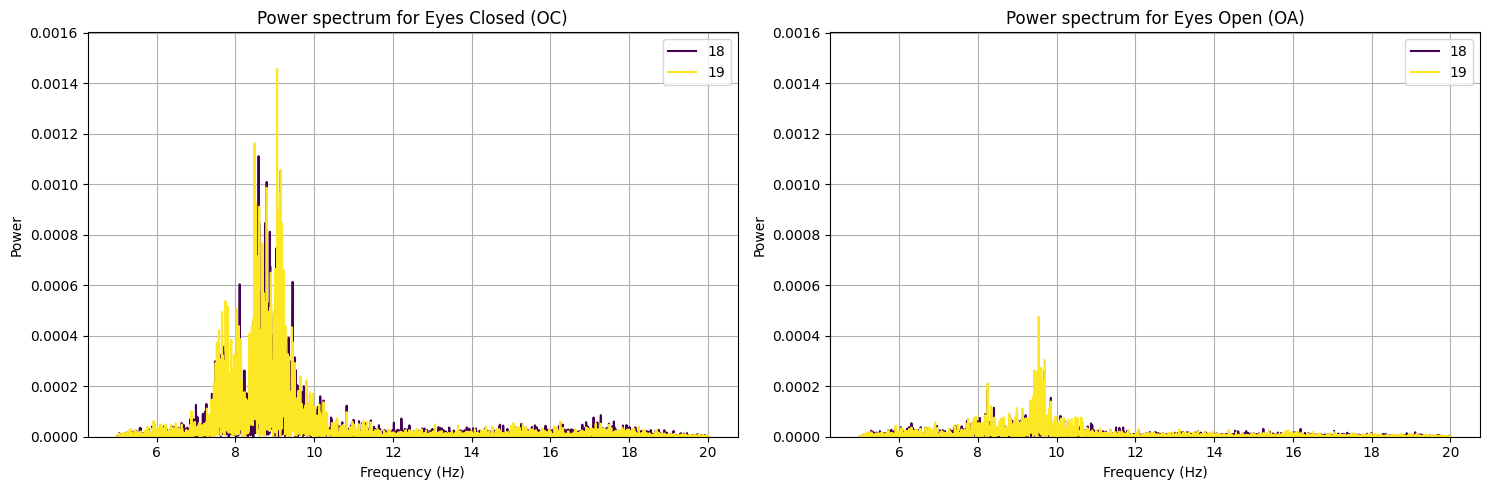

In [40]:
segments_to_plot = [0, 3, 5]
min_freq=5
max_freq=20
for segment in segments_to_plot:
    plt.subplots(1, 2, figsize=(15, 5))
    
    data_oc_time_filtered = bandpass_filter(data_oc_optical_channels[segment], min_freq, max_freq, sample_rate)
    data_oa_time_filtered = bandpass_filter(data_oa_optical_channels[segment], min_freq, max_freq, sample_rate)
    # Compute power spectra for both conditions
    freqs_oc, power_spectrum_oc = compute_power_spectrum(data_oc_time_filtered, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq)
    freqs_oa, power_spectrum_oa = compute_power_spectrum(data_oa_time_filtered, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq)
    
    # Determine the y-limit based on the maximum value of both power spectra
    y_max = max(power_spectrum_oc.max(), power_spectrum_oa.max())
    
    plt.subplot(1, 2, 1)
    plot_power_spectrum_overlay(freqs_oc, power_spectrum_oc, channel_names[optical_channel_slice], title=f"Power spectrum for Eyes Closed (OC)")
    plt.ylim([0, y_max + y_max / 10])
    plt.subplot(1, 2, 2)
    plot_power_spectrum_overlay(freqs_oa, power_spectrum_oa, channel_names[optical_channel_slice], title=f"Power spectrum for Eyes Open (OA)")
    plt.ylim([0, y_max + y_max / 10])
    plt.show()

**4. Now get the power spectra from the range that seems to be the most suited for classifying the difference between OC and OA based on the visual inspection you did above:**

In [ ]:
min_freq = 8
max_freq = 12

power_spectra_oc = [compute_power_spectrum(arr, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq) for arr in data_oc_optical_channels]
power_spectra_oa = [compute_power_spectrum(arr, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq) for arr
                    in data_oa_optical_channels]

*Let's plot this smaller spectrum*

In [ ]:
n_plots = 3
for (_, spectrum_oc), (_, spectrum_oa) in zip(power_spectra_oc, power_spectra_oa[:n_plots]):
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plot_power_spectrum_overlay(freqs_oc, spectrum_oc, ch_names=[17, 18], title=f"Power spectrum for Eyes Closed (OC)")
    plt.subplot(1, 2, 2)
    plot_power_spectrum_overlay(freqs_oa, spectrum_oa, ch_names=[17, 18], title=f"Power spectrum for Eyes Open (OA)")
    plt.ylim(spectrum_oc.min(), spectrum_oa.max())
    plt.show()

**5. Now let's compute the energies in this range and plot them**


*Hint: recall that the energy of a signal is given by $E = \sum_{n=0}^N f(n)^2$*

In [ ]:
alphas_oc = []
alphas_oa = []
for (freqs_oc, spectrum_oc), (freqs_oa, spectrum_oa) in zip(power_spectra_oc, power_spectra_oa):
    alpha_oc = np.sum(spectrum_oc ** 2)
    alpha_oa = np.sum(spectrum_oa ** 2)
    
    alphas_oc.append(alpha_oc)
    alphas_oa.append(alpha_oa)
alphas_oc = np.array(alphas_oc)
alphas_oa = np.array(alphas_oa)

In [ ]:
def plot_alphas(alphas_oc, alphas_oa, show=False, s = 10):
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.scatter(range(len(alphas_oc)), alphas_oc, label='OC', color='blue', s=s) 
    plt.scatter(range(len(alphas_oa)), alphas_oa, label='OA', color='orange', s=s)
    # The following line makes a line which you can change to illustrate a decision boundary:
    plt.title('OA and OC energy of alpha frequencies compared')
    plt.xlabel('Subject')
    plt.ylabel('Amplitude')
    plt.legend()
    
    plt.tight_layout()
    if show:
        plt.show()

In [ ]:
plot_alphas(alphas_oc, alphas_oa, show=True)

**6. Now that you have processed the data using the dft and inspected the energies of the two different cases, discuss how well you believe this data could be used to create a classifier that classifies whether a person has their eyes open or close:**



### Exercise 4 Classification

*This exercise is here to ties what you learned in weeks 1-3 together with signals processing. Specifically we will implement a CNN to do classification on the EEG data. Here you can spend as much time and effort as you wish refining the classification or coming up with other techniques, but be warned EEG data is notoriously noisy.*

In [ ]:
def cross_validation_split(data_oc, data_oa, hold_out_val, i, device, as_arrays=False):
    """
    Performs cross-validation split for one of time, frequency, or alpha data.
    
    Args:
        data_oc (list or array): Optical channels (oc) data.
        data_oa (list or array): Optical amplifiers (oa) data.
        hold_out_val (int): Number of elements to hold out in each fold.
        i (int): Current fold index.
    
    Returns:
        train_current (list or array): Training set for current fold.
        val_current (list or array): Validation set for current fold.
    """    
    # Define slices for validation and training sets
    slice_val = slice(i * hold_out_val, (i + 1) * hold_out_val)
    before_slice = slice(0, i * hold_out_val)
    after_slice = slice((i + 1) * hold_out_val, None)
    # Validation sets
    val_current_oc = data_oc[slice_val]
    val_current_oa = data_oa[slice_val]
    
    # Training sets (excluding validation slices)
    train_current_oc = data_oc[before_slice] + data_oc[after_slice]
    train_current_oa = data_oa[before_slice] + data_oa[after_slice]
    
    # Combine oc and oa for the current fold
    val_current = val_current_oc + val_current_oa
    train_current = train_current_oc + train_current_oa
    
    val_targets = [0 for _ in val_current_oc] + [1 for _ in val_current_oa]
    train_targets = [0 for _ in train_current_oc] + [1 for _ in train_current_oa]
    if as_arrays:
        return train_current_oc, train_current_oa, val_current_oc, val_current_oa
    else:
        train_set = SimpleDataset(train_current, train_targets, device)
        val_set = SimpleDataset(val_current, val_targets, device)
        
        return train_set, val_set
        

**1. Define the parameters of the CNN**

In [ ]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

class CNN(torch.nn.Module):
    def __init__(self, num_classes, in_channels=1, lr=0.001):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.lr = lr
        self.define_network()
    
    def define_network(self):
        # Define layers as a torch.nn.Sequential object
        # This is pretty nice, since we can just go layers(input) to get output
        # Rather than having a bunch of functions in the forward function
        self.layers = torch.nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=32, kernel_size=3, padding=1), # dim = in
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(out_features=600),    # Automatically infers the input dimension
            nn.ReLU(),
            nn.Linear(in_features=600, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=self.num_classes)
        ).to(device)
                
        # Loss function and optimizer, as you know, Adam is the meta
        self.criterion = nn.CrossEntropyLoss()
        self.optim = torch.optim.Adam(self.layers.parameters(), lr=self.lr)

    def forward(self, x):
        return self.layers(x)

    def train(self, train_dataloader, epochs=1, val_dataloader=None, run_filepath=""):
        
        # To hold accuracy during training and testing
        train_accs = []
        test_accs = []
        for epoch in tqdm(range(epochs), desc=f'Training'):
            
            path_epoch = join(run_filepath, f"{epoch}.pth")
            os.makedirs(os.path.dirname(path_epoch), exist_ok=True)
            if os.path.exists(path_epoch):
                self.load_model(path_epoch)
                print(f"Loaded model from {path_epoch}. Skipping epoch.")
                
            epoch_acc = 0

            for inputs, targets in tqdm(train_dataloader):
                logits = self(inputs)
                loss = self.criterion(logits, targets)
                loss.backward()

                self.optim.step()
                self.optim.zero_grad()

                # Not actually used for training, just for keeping track of accuracy
                epoch_acc += (torch.argmax(logits, dim=1) == targets).sum().item()
            
            self.save_model(path_epoch)
            train_accs.append(epoch_acc / len(train_dataloader.dataset))
            print(f"Epoch {epoch} training accuracy: {epoch_acc / len(train_dataloader.dataset)}")

            # If we have val dataloader, we can evaluate after each epoch
            if val_dataloader is not None:
                acc = self.eval(val_dataloader)
                test_accs.append(acc)
                print(f"Epoch {epoch} validation accuracy: {acc}")
        
        return train_accs, test_accs

    def eval(self, test_dataloader):
        
        total_acc = 0

        for input_batch, label_batch in test_dataloader:
            # Get predictions
            logits = self(input_batch)

            # Remember, outs are probabilities (so there's 10 for each input)
            # The classification the network wants to assign, must therefore be the probability with the larget value
            # We find that using argmax (dim=1, because dim=0 would be across batch dimension)
            classifications = torch.argmax(logits, dim=1)
            total_acc += (classifications == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)

        return total_acc
    
    def save_model(self, path):
        torch.save({
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': self.optim.state_dict()
        }, path)
        print(f"Model saved to {path}")

    # Load model method
    def load_model(self, path):
        checkpoint = torch.load(path)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.optim.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Model loaded from {path}")

**2. Define the parameters of a Feed Forward Neural Network**

In [ ]:
class FFNN(CNN):
    def __init__(self, num_classes, in_channels=1, lr=0.001):
        super().__init__(num_classes, in_channels, lr)
        
    def define_network(self):
        self.layers = torch.nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(out_features=600),
            nn.ReLU(),
            nn.Linear(in_features=600, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=self.num_classes)
        ).to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.optim = torch.optim.Adam(self.layers.parameters(), lr=self.lr)

*Boilerplate torch dataset definition*

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SimpleDataset(Dataset):
    def __init__(self, time_data, targets, device, dtype_data=torch.float32, dtype_targets=torch.long):
        """
        Args:
            time_data (list or array): Training time data.
            targets (list or array): Corresponding target values (labels).
        """
        self.data = time_data
        self.targets = targets
        self.device = device
        self.dtype_data = dtype_data
        self.dtype_targets = dtype_targets

    def __len__(self):
        # Return the total number of samples
        assert len(self.data) == len(self.targets)
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve a single sample (time data and corresponding target)
        sample = self.data[idx]
        target = self.targets[idx]
        sample = torch.tensor(sample).to(dtype=self.dtype_data).to(device)
        target = torch.tensor(target).to(dtype=self.dtype_targets).to(device)
        if sample.ndim == 2:
            sample = sample.unsqueeze(0)
        
        # Optionally convert to torch tensors if needed
        return sample, target

**3. The following is a VERY simple way of calculating a threshold. What could you do to make it more sophisticated? (Feel free to implement you more sophisticated method!)**

In [ ]:
def simple_threshold_calculator(vec1, vec2):
    m1 = np.mean(vec1)
    m2 = np.mean(vec2)
    return np.mean([m1, m2])

**4. Now use the models you have defined above in cross-validation loops that each use the EEG data in different ways. Here we have set up the following 4 loops, but feel free to experiment with other configurations:**

- Threshold on alpha energy
- CNN on frequency domain
- CNN on Time domain
- FFNN on frequency domain

*The pytorch models will be saved in a folder named 'models' and can be loaded from there. The test loop automatically loads a model if it has the same name as the one it is about to train thus skipping the epoch.*

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

hold_out_val = 1
hold_out_test = 2

# Assuming the oc and oa data are already concatenated, split them back to separate.
train_set_time_oc = data_oc_optical_channels[:-hold_out_test]
train_set_time_oa = data_oa_optical_channels[:-hold_out_test]

train_set_frequency_oc = [el[1] for el in power_spectra_oc[:-hold_out_test]]
train_set_frequency_oa = [el[1] for el in power_spectra_oa[:-hold_out_test]]

train_set_alpha_oc = alphas_oc[:-hold_out_test]
train_set_alpha_oa = alphas_oa[:-hold_out_test]

k_folds = len(train_set_alpha_oc) // hold_out_val

In [ ]:
run_name = join(os.getcwd(), "models", "testing-freq-threshold")

val_accuracies_threshold = []
for i in tqdm(range(k_folds), desc=f"Cross-validation {os.path.basename(run_name)}"):
    # Combine oc and oa for the current fold
    train_oc, train_oa, val_oc, val_oa = cross_validation_split(alphas_oc.tolist(), alphas_oa.tolist(), hold_out_val, i, device=device, as_arrays=True)
    
    threshold = simple_threshold_calculator(train_oc, train_oa)
    acc = (val_oc > threshold) + (threshold < val_oa)
    val_accuracies_threshold.append(acc)

In [ ]:
run_name = join(os.getcwd(), "models", "testing-time-CNN")
val_accuracies_cnn_time = []
epochs_CNN_time = 1
# Cross-validation loop
for i in tqdm(range(k_folds), desc=f"Cross-validation {os.path.basename(run_name)}"):
    # Combine oc and oa for the current fold
    train_set_current, val_set_current = cross_validation_split(train_set_time_oc, train_set_time_oa, hold_out_val, i, device=device)
    
    CNN_time = CNN(num_classes=2)
    CNN_time.train(DataLoader(train_set_current), epochs=epochs_CNN_time, run_filepath=f"{run_name}-{i}")
    val_cnn_time = CNN_time.eval(DataLoader(val_set_current))
    val_accuracies_cnn_time.append(val_cnn_time)

In [ ]:
run_name = join(os.getcwd(), "models", "testing-freq-CNN")
val_accuracies_cnn_freq = []
epochs_CNN_freq = 10

for i in tqdm(range(k_folds), desc=f"Cross-validation {os.path.basename(run_name)}"):
    # Combine oc and oa for the current fold
    train_set_current, val_set_current = cross_validation_split(train_set_frequency_oc, train_set_frequency_oa, hold_out_val, i, device=device)
    
    CNN_freq = CNN(num_classes=2)
    CNN_freq.train(DataLoader(train_set_current), epochs=epochs_CNN_freq, run_filepath=f"{run_name}-{i}")
    val_cnn_freq = CNN_freq.eval(DataLoader(val_set_current))
    val_accuracies_cnn_freq.append(val_cnn_freq)

In [ ]:
run_name = join(os.getcwd(), "models", "testing-freq-FFNN")
epochs_FFNN = 2
val_accuracies_fnn_freq = []
for i in tqdm(range(k_folds), desc=f"Cross-validation {os.path.basename(run_name)}"):
    # Combine oc and oa for the current fold
    train_set_current, val_set_current = cross_validation_split(train_set_frequency_oc, train_set_frequency_oa, hold_out_val, i, device=device)
    
    FFNN_freq = FFNN(num_classes=2)
    FFNN_freq.train(DataLoader(train_set_current), epochs=epochs_FFNN, run_filepath=f"{run_name}-{i}")
    val_cnn_freq = FFNN_freq.eval(DataLoader(val_set_current))
    val_accuracies_fnn_freq.append(val_cnn_freq)

In [ ]:
# Calculate means
# Small value to prevent division by zero
epsilon = 1e-8

# Calculate means
mean_cnn_time = [sum(val_accuracies_cnn_time) / (len(val_accuracies_cnn_time) + epsilon)] * len(val_accuracies_cnn_time)
mean_cnn_freq = [sum(val_accuracies_cnn_freq) / (len(val_accuracies_cnn_freq) + epsilon)] * len(val_accuracies_cnn_freq)
mean_fnn_freq = [sum(val_accuracies_fnn_freq) / (len(val_accuracies_fnn_freq) + epsilon)] * len(val_accuracies_fnn_freq)
mean_threshold = [sum(val_accuracies_threshold) / (len(val_accuracies_threshold) + epsilon)] * len(val_accuracies_threshold)

# Plotting
# Plotting
plt.figure(figsize=(8, 6))
cnn_time_color = 'blue'  # Example color for CNN Time
cnn_freq_color = 'orange'  # Example color for CNN Freq
fnn_freq_color = 'green'  # Example color for FNN Freq
threshold_color = 'red'  # Example color for Threshold

plt.plot(val_accuracies_cnn_time, label='CNN Time', marker='o', color=cnn_time_color)
plt.plot(val_accuracies_cnn_freq, label='CNN Freq', marker='s', color=cnn_freq_color)
plt.plot(val_accuracies_fnn_freq, label='FNN Freq', marker='^', color=fnn_freq_color)
plt.plot(val_accuracies_threshold, label='Threshold', marker='d', color=threshold_color)

# Plot means with low alpha, matching colors
plt.plot(mean_cnn_time, label='Mean CNN Time', linestyle='--', alpha=0.3, color=cnn_time_color)
plt.plot(mean_cnn_freq, label='Mean CNN Freq', linestyle='--', alpha=0.3, color=cnn_freq_color)
plt.plot(mean_fnn_freq, label='Mean FNN Freq', linestyle='--', alpha=0.3, color=fnn_freq_color)
plt.plot(mean_threshold, label='Mean Threshold', linestyle='--', alpha=0.3, color=threshold_color)

plt.title('Validation Accuracies with Means')
plt.xlabel('Index')
plt.ylabel('Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()


**5. How did it go?**